In [20]:
from copy import deepcopy
import numpy as np
import scipy.ndimage as ndi
from aquapointer.analog.utils import detuning_scale_utils as dsu
from aquapointer.slicing import density_file_to_grid, density_slices_by_axis, density_slices_by_plane, density_origin, density_point_boundaries, crop_slices
import matplotlib.pyplot as plt

In [2]:
grid = density_file_to_grid("../data/3D-RISM_densities/1NNC/prot_3drism.O.1.dx")

In [3]:
print(density_origin(grid))
print(density_point_boundaries(grid))

[ 6.694 -3.659 41.76 ]
[46.694 36.341 81.76 ]


In [17]:
canvases = density_slices_by_axis(grid, axis=np.array([0, 0, 1]), distances=np.array([10, 20, 30]))

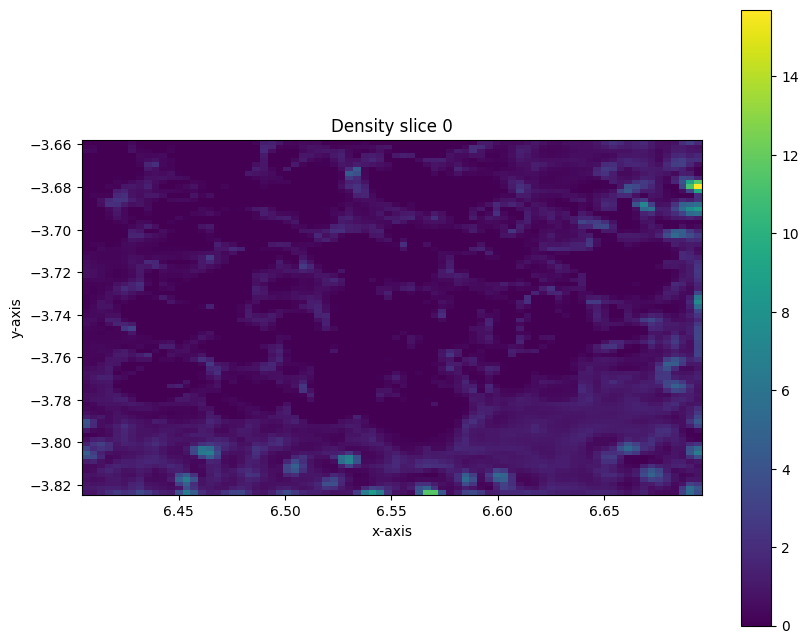

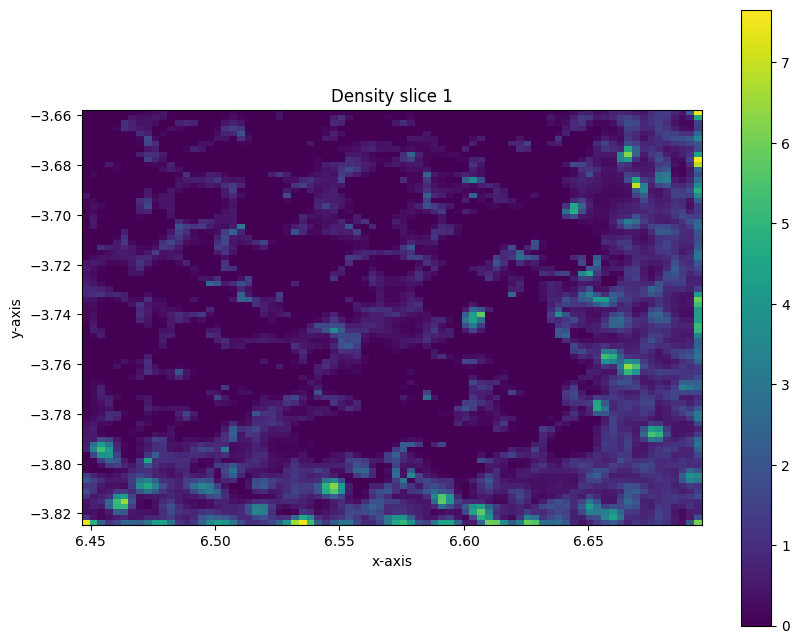

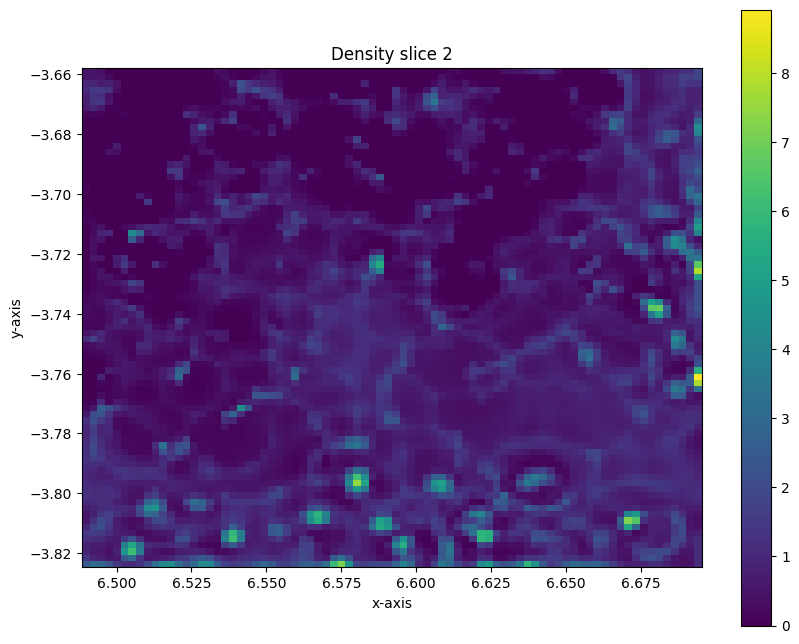

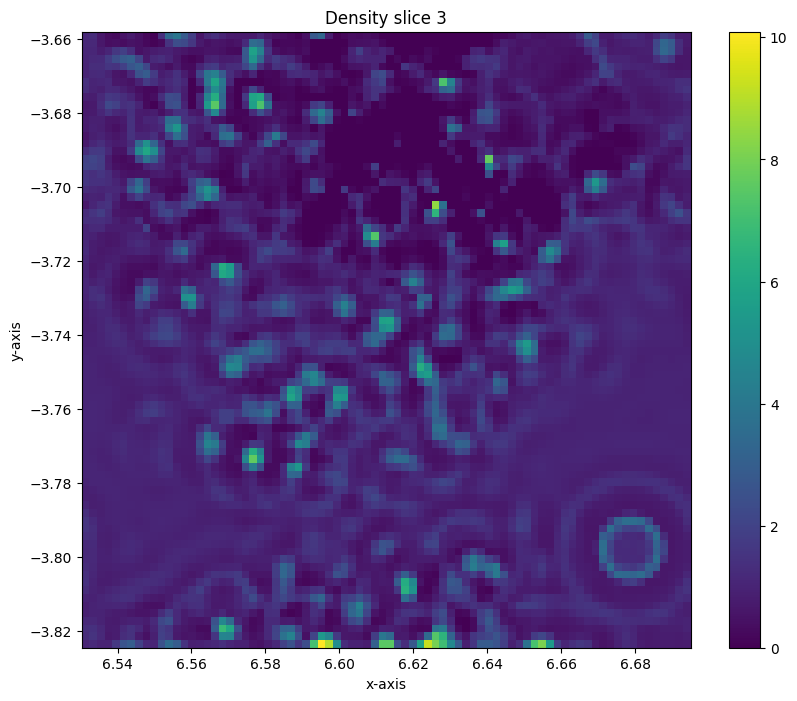

In [18]:
for c, canvas in enumerate(canvases):
    canvas.draw(title=f"Density slice {c}")

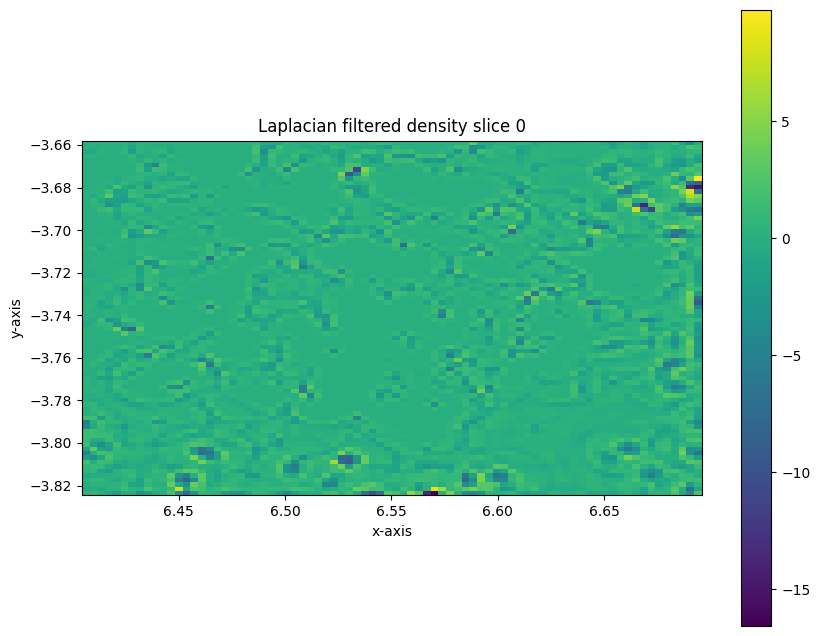

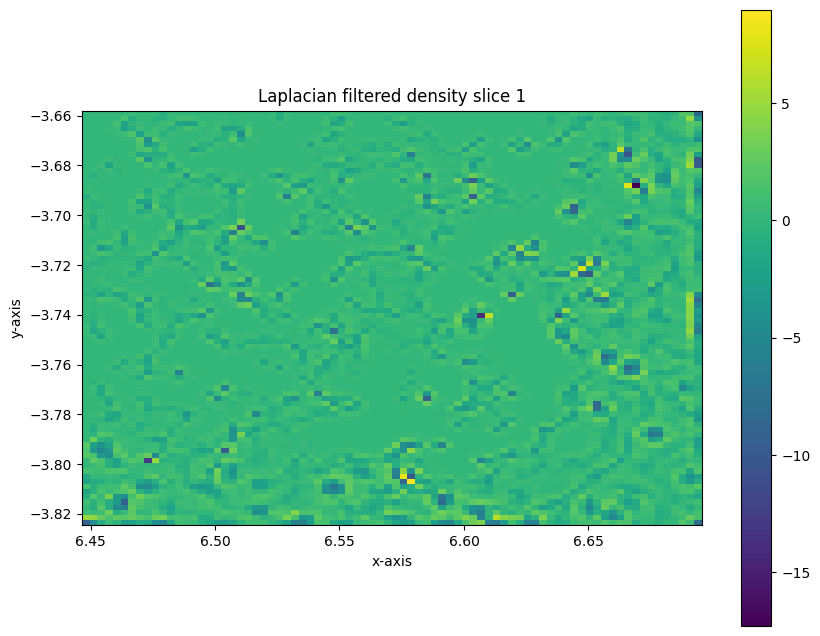

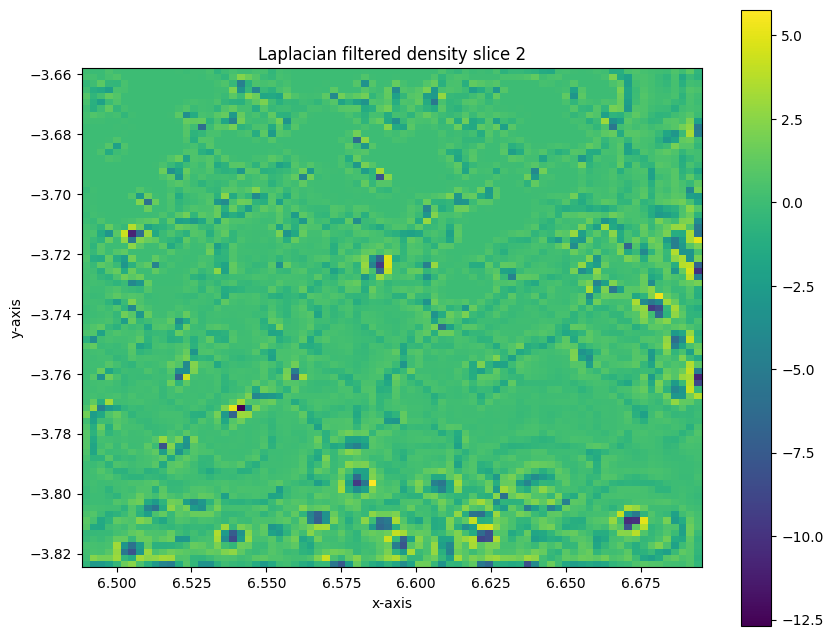

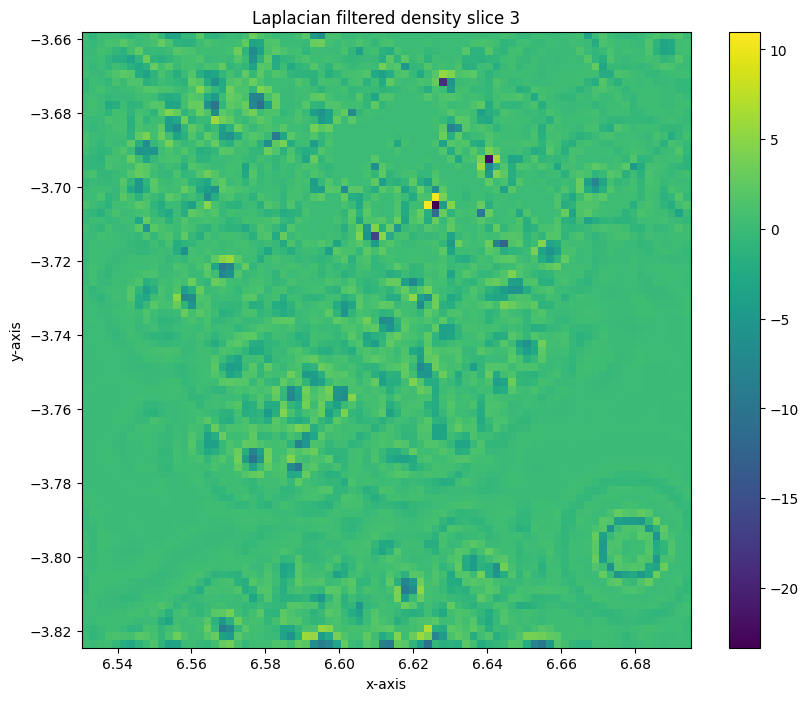

In [21]:
for c, canvas in enumerate(canvases):
    filtered = deepcopy(canvas)
    filtered.filter_density(filter_settings={"filter_function": ndi.laplace})
    filtered.draw(title=f"Laplacian filtered density slice {c}")

In [6]:
og = density_origin(grid)
slicing_planes = [(og + np.array([5, 10, 8]), np.array([0, 1, 1])), (og + np.array([15, 16, 20]), np.array([0, 1, 1])), (og + np.array([25, 22, 32]), np.array([0, 1, 1]))]
canvases_1nnc = density_slices_by_plane(grid, slicing_planes)

ValueError: The slice must have shape (86, 80)

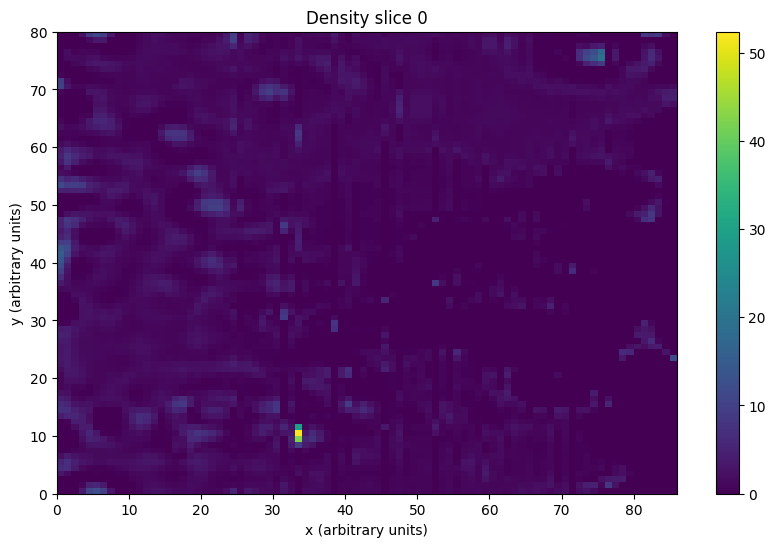

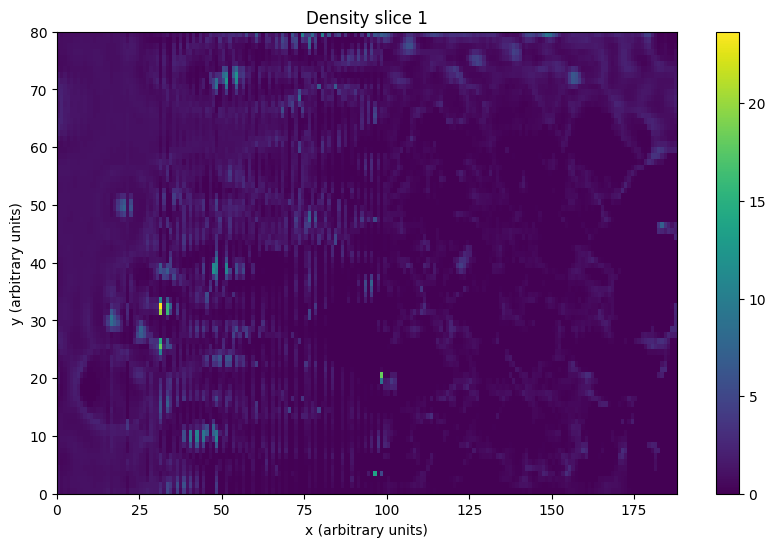

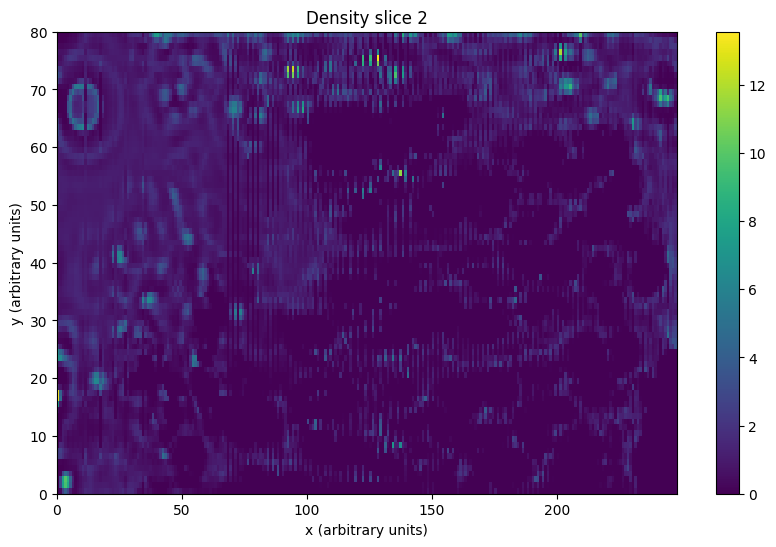

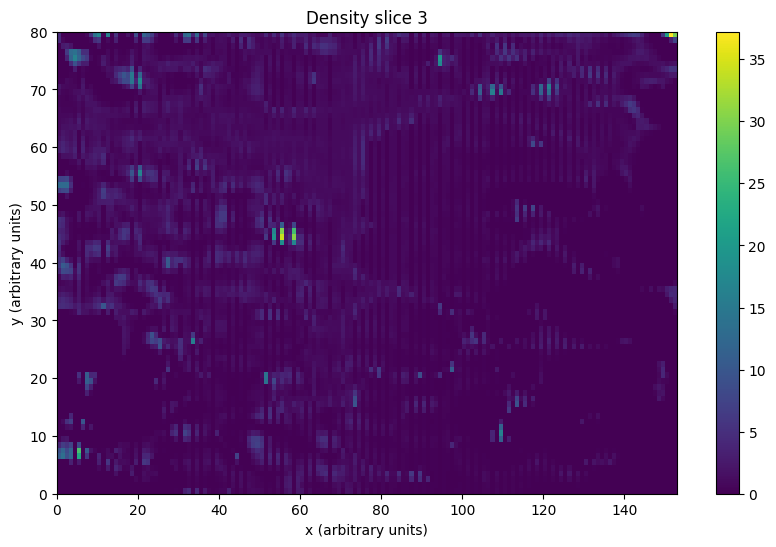

In [7]:
for c, canvas in enumerate(canvases_1nnc):
    canvas.plotting_objects(title=f"Density slice {c}")

In [69]:
cropped_canvases_1nnc = crop_slices(points_1nnc, densities_1nnc, x_ranges = [(points_1nnc[2][20, 20, 0], points_1nnc[2][60, 20, 0])], y_ranges = [(points_1nnc[2][20, 20, 1], points_1nnc[3][20, 60, 1])])

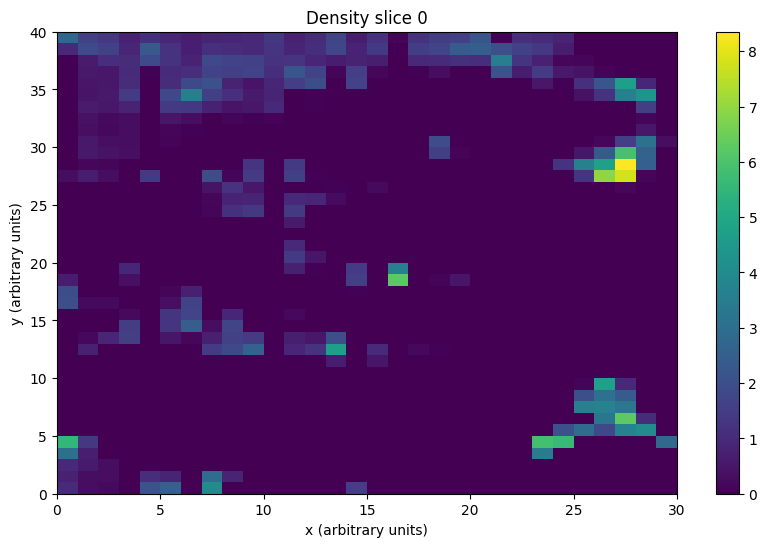

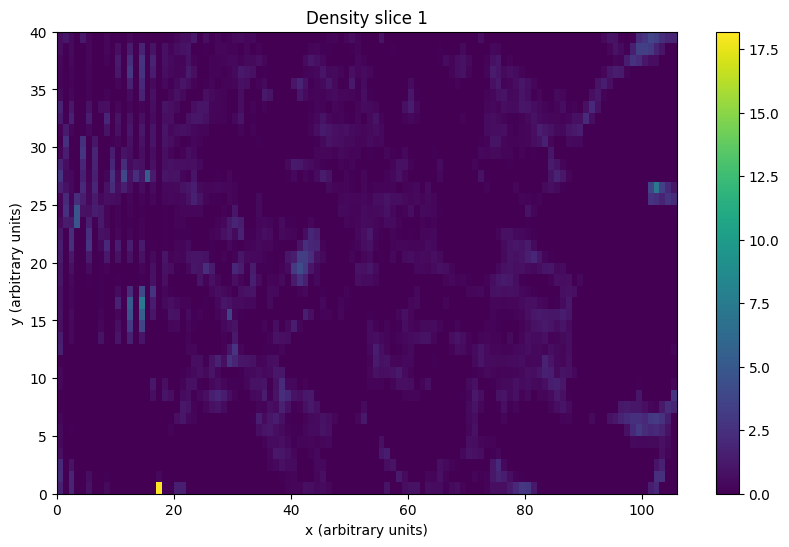

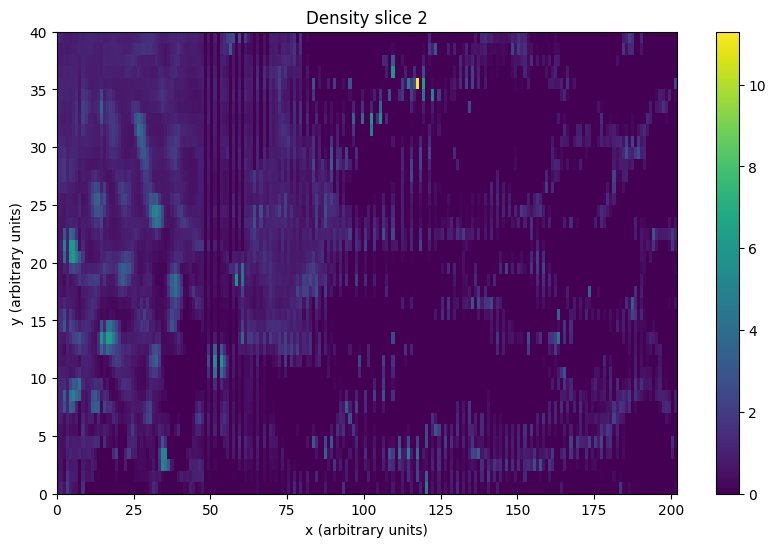

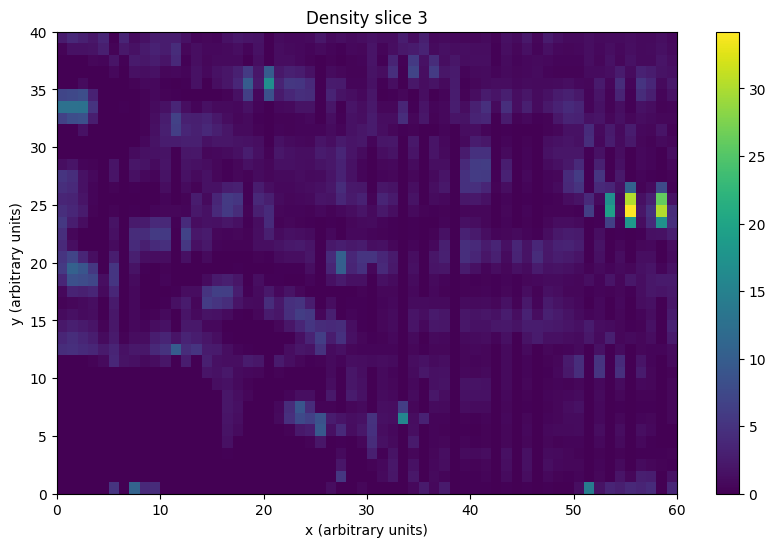

In [70]:
for c, canvas in enumerate(cropped_canvases_1nnc):
    canvas.plotting_objects(title=f"Density slice {c}")

In [7]:
grid_bd = density_file_to_grid("../data/3D-RISM_densities/bromoD/prot_3drism.O.1.dx")

In [8]:
print(density_origin(grid_bd))
print(density_point_boundaries(grid_bd))

[101.906 -26.182 -20.756]
[141.906  13.818  19.244]


In [10]:
canvases_bd = density_slices_by_axis(grid, axis=np.array([0, 1, 0]), distances=np.linspace(5, 35, 7, dtype=int))

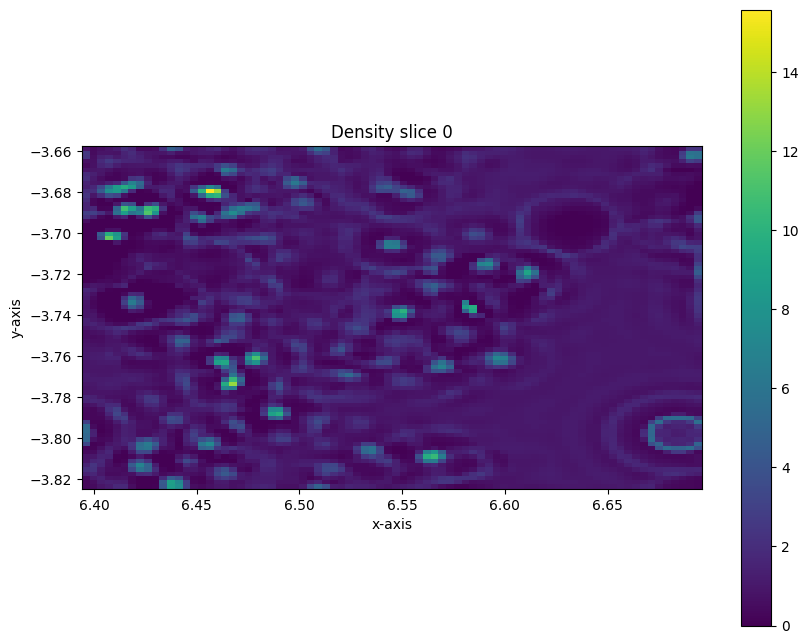

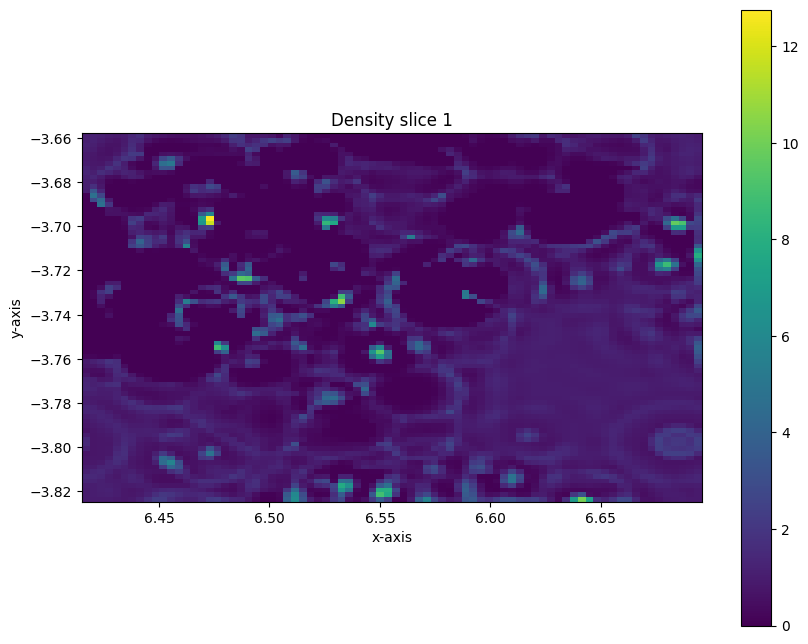

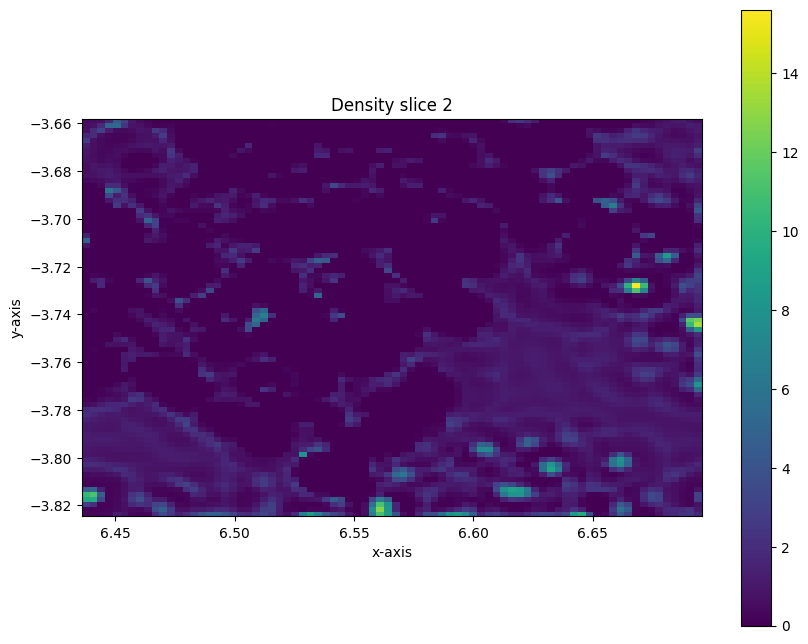

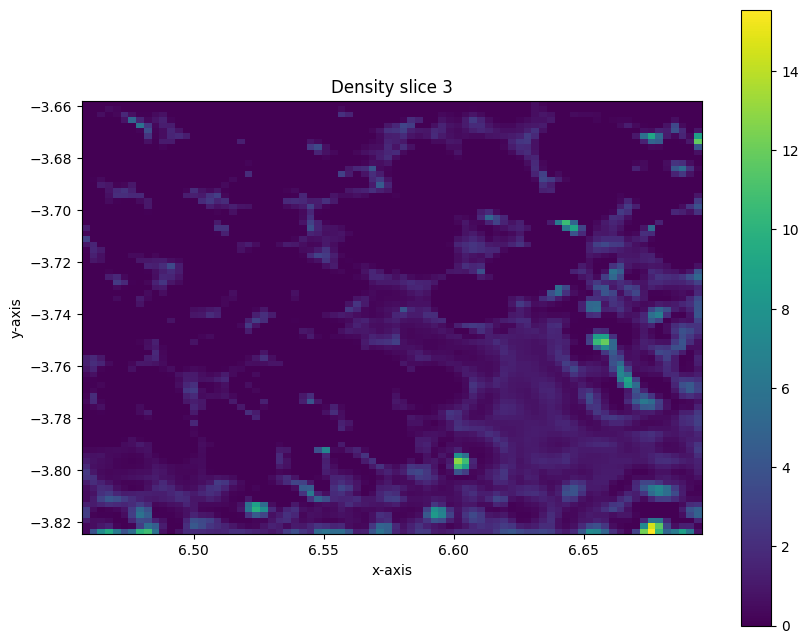

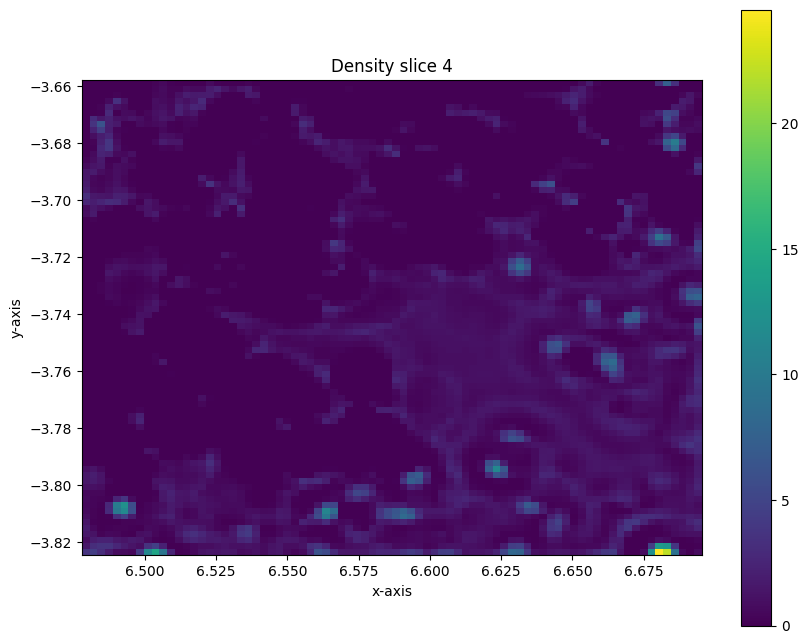

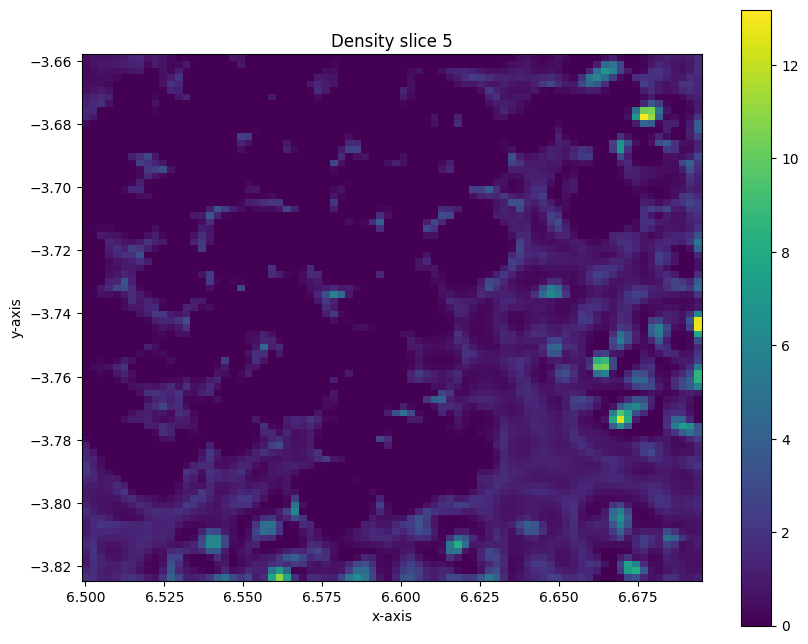

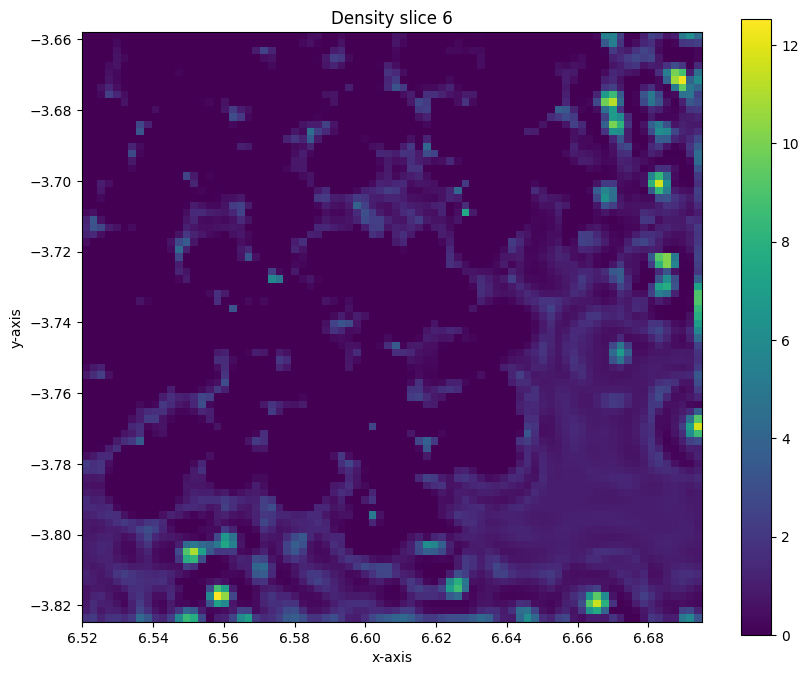

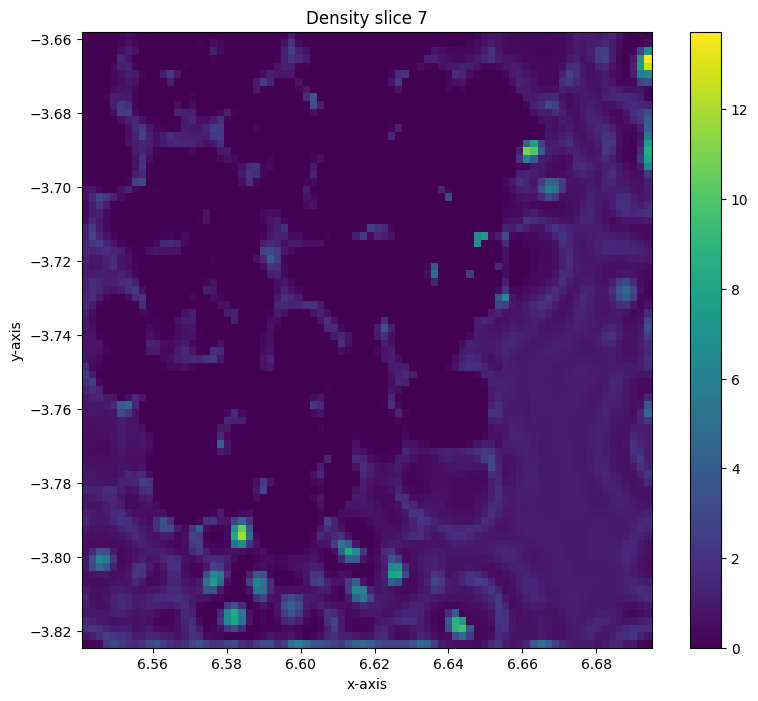

In [12]:
for c, canvas in enumerate(canvases_bd):
    canvas.plotting_objects(title=f"Density slice {c}")

In [ ]:
grid_dh = density_file_to_grid("../data/3D-RISM_densities/dehydratase/prot_3drism_dT.O.1.dx")

In [ ]:
print(density_origin(grid_dh))
print(density_point_boundaries(grid_dh))

[ -9.293  -6.514 -10.821]
[30.707 33.486 29.179]


In [ ]:
points_dh, densities_dh = density_slices_by_axis(grid, axis=np.array([1, 0, 0]), distances=np.linspace(8, 32, 4, dtype=int))

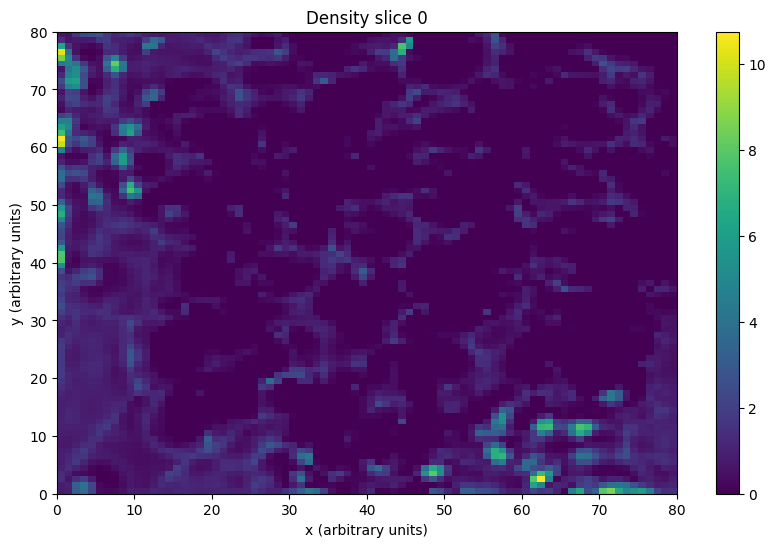

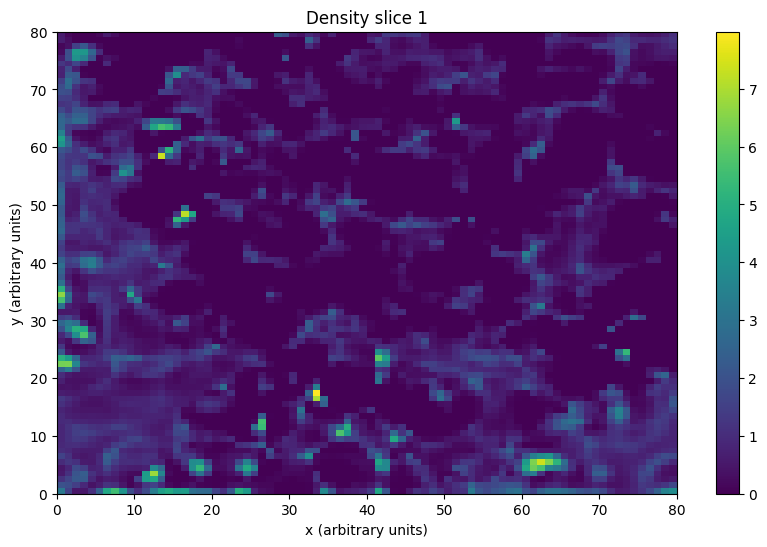

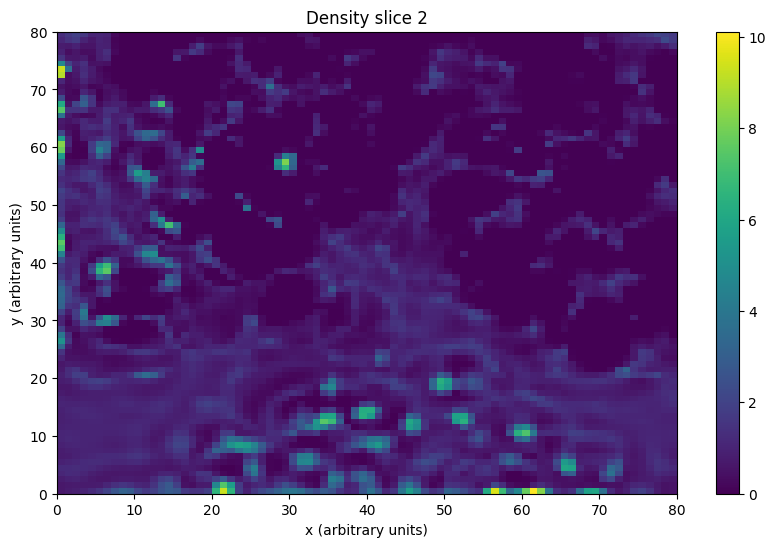

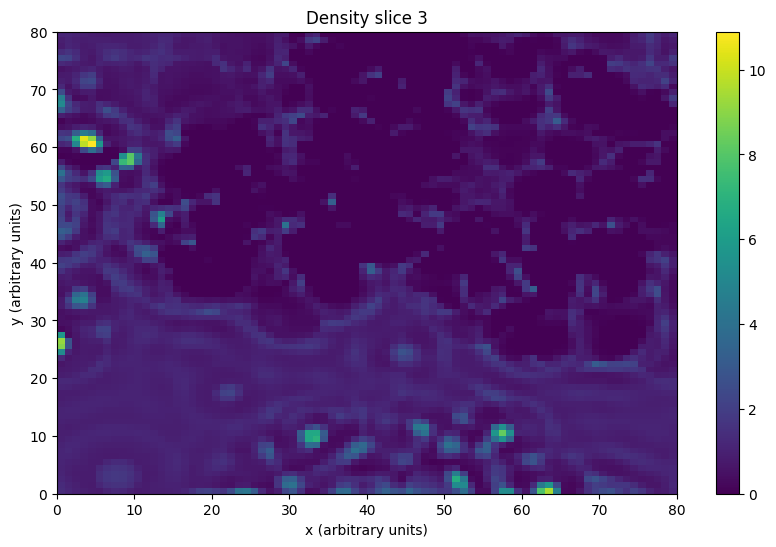

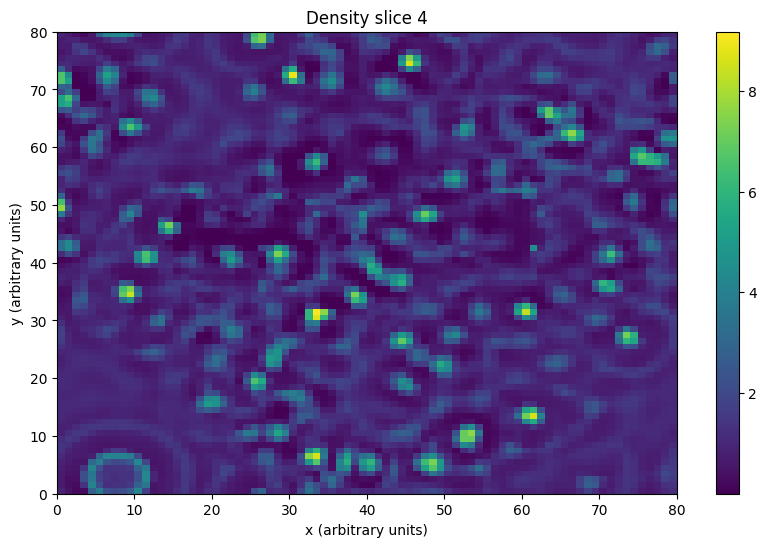

In [ ]:
for k, density in enumerate(densities_dh):
    fig, ax = dsu.plot_density(
            density, title=f"Density slice {k}"
        )
plt.show()

In [ ]:
# AQUAPOINTING

from pulser import Register
from pulser.devices import MockDevice, AnalogDevice
from pulser_simulation import QutipBackend
import pickle

from aquapointer import water_placement, processor


In [ ]:
# import registers
path = "../registers/"
basename = "position_"
positions = []
registers = []
d_list = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5]
for i in range(len(d_list)):
    with open(f'../registers/position_{i}.npy', 'rb') as file_in:
        pos = np.load(file_in)
    positions.append(pos)
    registers.append(Register.from_coordinates(pos)) # this is to create a Pulser register object

basename = "rescaled_position_"
rescaled_positions = []
for i in range(len(d_list)):
    with open(f'../registers/rescaled_position_{i}.npy', 'rb') as file_in:
        res_pos = np.load(file_in)
    rescaled_positions.append(res_pos)

In [ ]:
# choose the maximum detuning allowed
max_det = AnalogDevice.channel_objects[0].max_abs_detuning-1

# choose a blockade radius (in micrometers)
# which in turns defines a Rabi frequency
brad = 7
omega = AnalogDevice.rabi_from_blockade(brad)

# choose a pulse duration
T = 3000

pulse_settings = processor.PulseSettings(brad=brad, omega=omega, pulse_duration=T, max_det=max_det)
processor_configs = [processor.AnalogProcessor(device=MockDevice, pos=pos, pos_id=p, pulse_settings=pulse_settings) for p, pos in enumerate(positions)]

In [ ]:
def executor(pulse_seq, num_samples):
    sim = QutipBackend(pulse_seq)
    res = sim.run()
    return res.sample_final_state(num_samples)

In [ ]:
test_water_postions = water_placement.find_water_positions(densities, points, executor, processor_configs)

In [ ]:
print(test_water_postions)

[array([33.194, 25.341, 46.76 ]), array([38.694, 28.841, 56.76 ]), array([25.194,  8.341, 66.76 ]), array([38.694, 28.841, 66.76 ]), array([19.694, -0.659, 66.76 ]), array([22.694, 16.341, 76.76 ]), array([33.194, 25.341, 76.76 ]), array([19.694,  5.341, 76.76 ])]
